# Bike Shares Project:

Trying to predict demand in the whole city per season / per day in the week /  per hour in the day / per day in the year

We will be working with datasets of 7 different cities:  
Austin, San Francisco, LA, Chicago, London, DC, Ottawa

Datasets include:
        - time of year / time of day / hour info
        - weather info (3 of them)
        - holidays, weekends & weekdays

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 14
import pgeocode
plt.style.use('ggplot')
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import scipy.stats as stats

from pygeocoder import Geocoder
from pandas.api.types import CategoricalDtype

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from googletrans import Translator

from sklearn.preprocessing import StandardScaler

Loading, Cleaning Data:

#  San Francisco:

In [3]:
sf = pd.read_pickle('../pickled_data/sf_trips_df.pickled')

In [4]:
sf.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,date,Start_Day,End_Day,Month,is_workday
0,4576,63,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,520,Subscriber,8/29/2013,Thursday,Thursday,August,1
1,4607,70,2013-08-29 14:42:00,San Jose City Hall,10,2013-08-29 14:43:00,San Jose City Hall,10,661,Subscriber,8/29/2013,Thursday,Thursday,August,1
2,4130,71,2013-08-29 10:16:00,Mountain View City Hall,27,2013-08-29 10:17:00,Mountain View City Hall,27,48,Subscriber,8/29/2013,Thursday,Thursday,August,1
3,4251,77,2013-08-29 11:29:00,San Jose City Hall,10,2013-08-29 11:30:00,San Jose City Hall,10,26,Subscriber,8/29/2013,Thursday,Thursday,August,1
4,4299,83,2013-08-29 12:02:00,South Van Ness at Market,66,2013-08-29 12:04:00,Market at 10th,67,319,Subscriber,8/29/2013,Thursday,Thursday,August,1


In [5]:
sf.shape

(669955, 15)

In [6]:
sf.subscription_type.value_counts()

Subscriber    566745
Customer      103210
Name: subscription_type, dtype: int64

Checking for NaN values:

In [7]:
sf.isnull().sum()

id                    0
duration              0
start_date            0
start_station_name    0
start_station_id      0
end_date              0
end_station_name      0
end_station_id        0
bike_id               0
subscription_type     0
date                  0
Start_Day             0
End_Day               0
Month                 0
is_workday            0
dtype: int64

In [8]:
sf.duration.min()

60

In [9]:
sf.dtypes

id                             int64
duration                       int64
start_date            datetime64[ns]
start_station_name            object
start_station_id               int64
end_date              datetime64[ns]
end_station_name              object
end_station_id                 int64
bike_id                        int64
subscription_type             object
date                          object
Start_Day                   category
End_Day                     category
Month                         object
is_workday                     int64
dtype: object

In [10]:
list(sf['Start_Day']) == list(sf['End_Day'])

False

In [12]:
# It seems like people rent a bike for longer thna a day  einai megala :/

In [16]:
sf.groupby('Start_Day')['id'].count()

Start_Day
Monday       115873
Tuesday      122259
Wednesday    120201
Thursday     119089
Friday       109360
Saturday      44783
Sunday        38390
Name: id, dtype: int64

Text(0, 0.5, 'Counts')

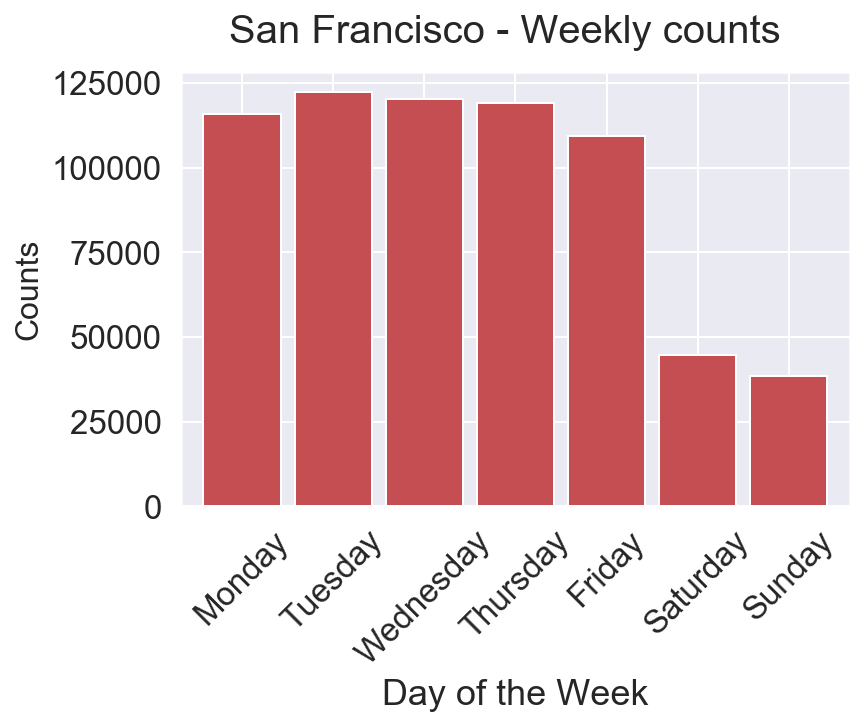

In [68]:
fig = plt.figure()
sf.groupby('Start_Day')['id'].count().plot(
    kind='bar', color='r', width=0.85)
fig.suptitle('San Francisco - Weekly counts', fontsize=20)
plt.xlabel('Day of the Week', fontsize=18)
plt.xticks(rotation=45)
plt.ylabel('Counts', fontsize=16)

In [19]:
sf.groupby('Start_Day')['duration'].mean()

Start_Day
Monday        852.989031
Tuesday       812.092819
Wednesday     833.807988
Thursday      874.311851
Friday       1043.918215
Saturday     2387.528281
Sunday       2509.360094
Name: duration, dtype: float64

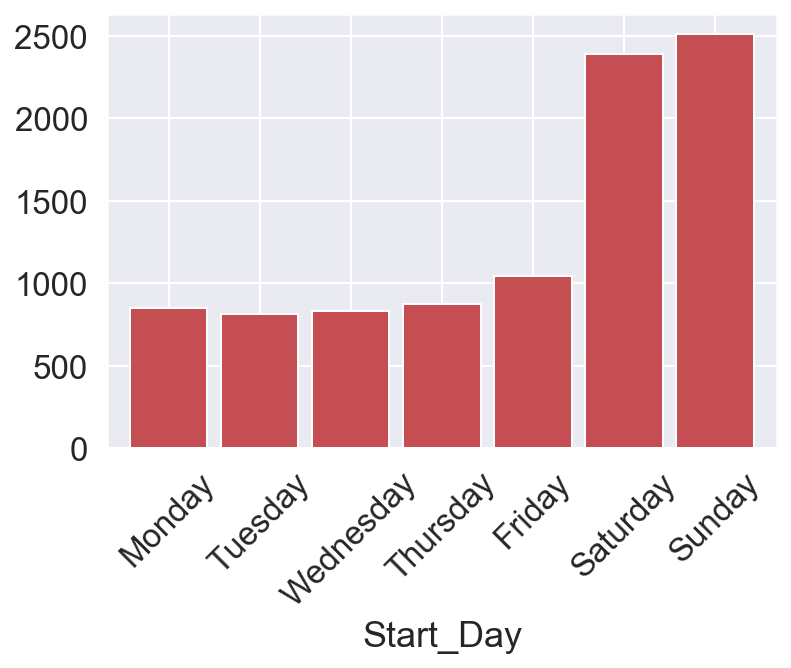

In [20]:
sf.groupby('Start_Day')['duration'].mean().plot(
    kind='bar', color='r', width=0.85)
plt.xticks(rotation=45)
plt.show()

In [24]:
# sf.groupby('End_Day')['duration'].mean().sort_index()


In [25]:
# sf.groupby('Start_Day')['duration'].mean().plot(
#     kind='bar', color='r', width=0.85)
# plt.xticks(rotation=45)
# plt.show()

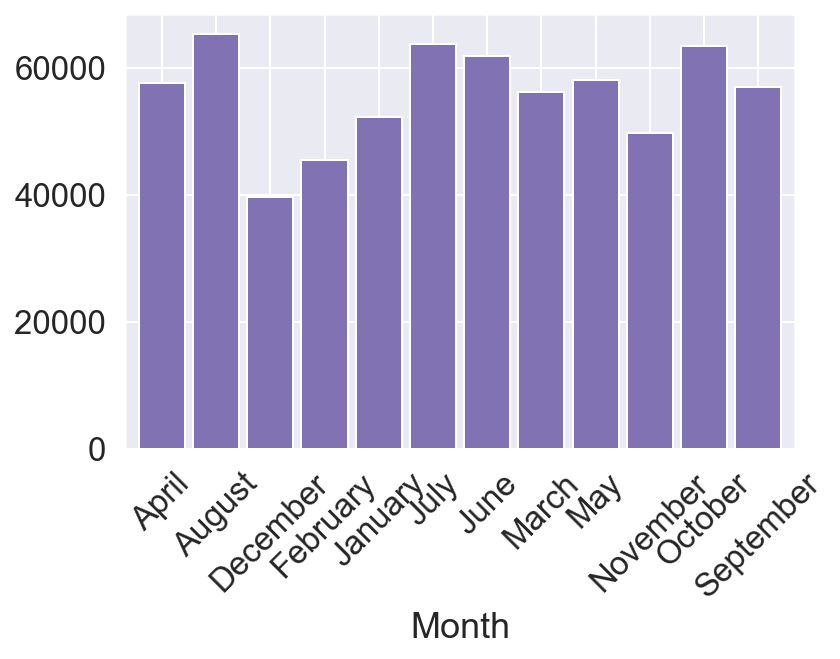

In [26]:
sf.groupby('Month')['id'].count().plot(
    kind='bar', color='m', width=0.85)
plt.xticks(rotation=45)
plt.show()

In [27]:
sf.date.dtypes

dtype('O')

# San Fran Weather:

In [28]:
sf_weather = pd.read_pickle('../pickled_data/sf_weather_df.pickled')

In [29]:
sf.shape

(669955, 15)

In [30]:
sf_weather.shape

(733, 25)

In [31]:
len(sf_weather.date.unique())

733

In [32]:
sf_weather.isnull().sum()

max_temperature_f                 0
mean_temperature_f                0
min_temperature_f                 0
max_dew_point_f                   0
mean_dew_point_f                  0
min_dew_point_f                   0
max_humidity                      0
mean_humidity                     0
min_humidity                      0
max_sea_level_pressure_inches     0
mean_sea_level_pressure_inches    0
min_sea_level_pressure_inches     0
max_visibility_miles              0
mean_visibility_miles             0
min_visibility_miles              0
max_wind_Speed_mph                0
mean_wind_speed_mph               0
cloud_cover                       0
wind_dir_degrees                  0
zip_code                          0
date                              0
mean_temperature_c                0
mean_dew_point_c                  0
mean_visibility_km                0
mean_wind_speed_kmh               0
dtype: int64

In [33]:
sf_weather.head()

,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,max_sea_level_pressure_inches,...,max_wind_Speed_mph,mean_wind_speed_mph,cloud_cover,wind_dir_degrees,zip_code,date,mean_temperature_c,mean_dew_point_c,mean_visibility_km,mean_wind_speed_kmh
Datetime,,,,,,,,,,,,,,,,,,,,,
2013-08-29,78.6,70.4,62.8,62.6,60.0,58.0,88.8,73.2,53.0,30.064,...,17.8,7.4,4.2,325.8,94325,8/29/2013,21.333333,15.555556,16.09,11.9066
2013-08-30,84.6,73.0,62.4,63.4,59.8,55.8,90.8,68.8,42.4,30.054,...,19.4,5.6,2.0,181.8,94325,8/30/2013,22.777778,15.444444,16.09,9.0104
2013-08-31,76.4,68.0,59.8,59.6,57.2,54.4,88.2,70.8,51.6,29.994,...,18.4,7.4,1.0,324.6,94325,8/31/2013,20.000000,14.000000,16.09,11.9066
2013-09-01,79.2,70.0,61.0,61.2,57.2,53.6,83.4,66.8,44.4,29.962,...,18.6,7.2,2.2,318.8,94325,9/1/2013,21.111111,14.000000,16.09,11.5848
2013-09-02,77.4,70.8,64.6,62.8,60.8,58.4,85.8,74.0,58.8,29.972,...,18.2,7.4,5.0,311.4,94325,9/2/2013,21.555556,16.000000,16.09,11.9066


In [34]:
sf_weather.date.dtypes

dtype('O')

In [35]:
sf.date.dtypes

dtype('O')

In [36]:
print('                            WEATHER:')
print('MAX:',sf_weather.date.max(),'----------','MIN:',sf_weather.date.min())

                            WEATHER:
MAX: 9/9/2014 ---------- MIN: 1/1/2014


In [37]:
print('                            date:')
print('MAX:',sf.date.max(),'----------','MIN:',sf.date.min())

                            date:
MAX: 9/9/2014 ---------- MIN: 1/1/2014


In [38]:
print('                           START date:')
print('MAX:',sf.start_date.max(),'----------','MIN:',sf.start_date.min())

                           START date:
MAX: 2015-08-31 23:26:00 ---------- MIN: 2013-08-29 09:08:00


In [39]:
print('                           END date:')
print('MAX:',sf.end_date.max(),'----------','MIN:',sf.end_date.min())

                           END date:
MAX: 2015-08-31 23:39:00 ---------- MIN: 2013-08-29 09:11:00


In [40]:
sf[['date','start_date','end_date']].dtypes

date                  object
start_date    datetime64[ns]
end_date      datetime64[ns]
dtype: object

In [41]:
len(sf.date.unique())

733

In [42]:
len(sf_weather.date.unique())

733

In [43]:
sf_weather.date[0]

'8/29/2013'

In [44]:
sf.date[0]

'8/29/2013'

In [45]:
# san_fran.shape

In [46]:
sf.shape

(669955, 15)

In [47]:
# San francisco merged
san_fran = pd.read_pickle('../pickled_data/sf_all_df.pickled')

In [48]:
san_fran.isnull().sum()

id                                    0
duration                              0
start_date                            0
start_station_name                    0
start_station_id                      0
end_date                              0
end_station_name                      0
end_station_id                        0
bike_id                               0
subscription_type                     0
date                                  0
Start_Day                             0
End_Day                               0
Month                                 0
is_workday                            0
max_temperature_f                     0
mean_temperature_f                    0
min_temperature_f                     0
max_dew_point_f                       0
mean_dew_point_f                      0
min_dew_point_f                       0
max_humidity                          0
mean_humidity                         0
min_humidity                          0
max_sea_level_pressure_inches         0


In [49]:
san_fran.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,...,max_wind_Speed_mph,mean_wind_speed_mph,cloud_cover,wind_dir_degrees,zip_code,mean_temperature_c,mean_dew_point_c,mean_visibility_km,mean_wind_speed_kmh,mean_humidity_binary
0,4576,63,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,520,Subscriber,...,17.8,7.4,4.2,325.8,94325,21.333333,15.555556,16.09,11.9066,1.0
1,4607,70,2013-08-29 14:42:00,San Jose City Hall,10,2013-08-29 14:43:00,San Jose City Hall,10,661,Subscriber,...,17.8,7.4,4.2,325.8,94325,21.333333,15.555556,16.09,11.9066,1.0
2,4130,71,2013-08-29 10:16:00,Mountain View City Hall,27,2013-08-29 10:17:00,Mountain View City Hall,27,48,Subscriber,...,17.8,7.4,4.2,325.8,94325,21.333333,15.555556,16.09,11.9066,1.0
3,4251,77,2013-08-29 11:29:00,San Jose City Hall,10,2013-08-29 11:30:00,San Jose City Hall,10,26,Subscriber,...,17.8,7.4,4.2,325.8,94325,21.333333,15.555556,16.09,11.9066,1.0
4,4299,83,2013-08-29 12:02:00,South Van Ness at Market,66,2013-08-29 12:04:00,Market at 10th,67,319,Subscriber,...,17.8,7.4,4.2,325.8,94325,21.333333,15.555556,16.09,11.9066,1.0


In [50]:
san_fran.columns
# mean_humidity
# mean_temperature_f

Index(['id', 'duration', 'start_date', 'start_station_name',
       'start_station_id', 'end_date', 'end_station_name', 'end_station_id',
       'bike_id', 'subscription_type', 'date', 'Start_Day', 'End_Day', 'Month',
       'is_workday', 'max_temperature_f', 'mean_temperature_f',
       'min_temperature_f', 'max_dew_point_f', 'mean_dew_point_f',
       'min_dew_point_f', 'max_humidity', 'mean_humidity', 'min_humidity',
       'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
       'min_sea_level_pressure_inches', 'max_visibility_miles',
       'mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph',
       'mean_wind_speed_mph', 'cloud_cover', 'wind_dir_degrees', 'zip_code',
       'mean_temperature_c', 'mean_dew_point_c', 'mean_visibility_km',
       'mean_wind_speed_kmh', 'mean_humidity_binary'],
      dtype='object')

In [51]:
san_fran_humidity_median = san_fran.mean_humidity.median()

In [52]:
san_fran_temp_median = san_fran.mean_temperature_f.median()

In [53]:
san_fran["mean_humidity_binary"] = np.nan

In [54]:
san_fran.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,...,max_wind_Speed_mph,mean_wind_speed_mph,cloud_cover,wind_dir_degrees,zip_code,mean_temperature_c,mean_dew_point_c,mean_visibility_km,mean_wind_speed_kmh,mean_humidity_binary
0,4576,63,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,520,Subscriber,...,17.8,7.4,4.2,325.8,94325,21.333333,15.555556,16.09,11.9066,NaN
1,4607,70,2013-08-29 14:42:00,San Jose City Hall,10,2013-08-29 14:43:00,San Jose City Hall,10,661,Subscriber,...,17.8,7.4,4.2,325.8,94325,21.333333,15.555556,16.09,11.9066,NaN
2,4130,71,2013-08-29 10:16:00,Mountain View City Hall,27,2013-08-29 10:17:00,Mountain View City Hall,27,48,Subscriber,...,17.8,7.4,4.2,325.8,94325,21.333333,15.555556,16.09,11.9066,NaN
3,4251,77,2013-08-29 11:29:00,San Jose City Hall,10,2013-08-29 11:30:00,San Jose City Hall,10,26,Subscriber,...,17.8,7.4,4.2,325.8,94325,21.333333,15.555556,16.09,11.9066,NaN
4,4299,83,2013-08-29 12:02:00,South Van Ness at Market,66,2013-08-29 12:04:00,Market at 10th,67,319,Subscriber,...,17.8,7.4,4.2,325.8,94325,21.333333,15.555556,16.09,11.9066,NaN


In [55]:
san_fran.isnull().sum()

id                                     0
duration                               0
start_date                             0
start_station_name                     0
start_station_id                       0
end_date                               0
end_station_name                       0
end_station_id                         0
bike_id                                0
subscription_type                      0
date                                   0
Start_Day                              0
End_Day                                0
Month                                  0
is_workday                             0
max_temperature_f                      0
mean_temperature_f                     0
min_temperature_f                      0
max_dew_point_f                        0
mean_dew_point_f                       0
min_dew_point_f                        0
max_humidity                           0
mean_humidity                          0
min_humidity                           0
max_sea_level_pr

In [56]:
san_fran['mean_humidity_binary'][san_fran['mean_humidity'] > san_fran_humidity_median] =  1

/Users/vilvaki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [57]:
san_fran.isnull().sum()

id                                     0
duration                               0
start_date                             0
start_station_name                     0
start_station_id                       0
end_date                               0
end_station_name                       0
end_station_id                         0
bike_id                                0
subscription_type                      0
date                                   0
Start_Day                              0
End_Day                                0
Month                                  0
is_workday                             0
max_temperature_f                      0
mean_temperature_f                     0
min_temperature_f                      0
max_dew_point_f                        0
mean_dew_point_f                       0
min_dew_point_f                        0
max_humidity                           0
mean_humidity                          0
min_humidity                           0
max_sea_level_pr

In [58]:
san_fran['mean_humidity_binary'][san_fran['mean_humidity'] <= san_fran_humidity_median] =  0

/Users/vilvaki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [59]:
san_fran.isnull().sum()

id                                0
duration                          0
start_date                        0
start_station_name                0
start_station_id                  0
end_date                          0
end_station_name                  0
end_station_id                    0
bike_id                           0
subscription_type                 0
date                              0
Start_Day                         0
End_Day                           0
Month                             0
is_workday                        0
max_temperature_f                 0
mean_temperature_f                0
min_temperature_f                 0
max_dew_point_f                   0
mean_dew_point_f                  0
min_dew_point_f                   0
max_humidity                      0
mean_humidity                     0
min_humidity                      0
max_sea_level_pressure_inches     0
mean_sea_level_pressure_inches    0
min_sea_level_pressure_inches     0
max_visibility_miles        

In [60]:
san_fran.start_date.max(), san_fran.start_date.min()

(Timestamp('2015-08-31 23:26:00'), Timestamp('2013-08-29 09:08:00'))

In [61]:
# Ara auto einai to demand mou, poio apo ta 2? to prwto exei k wra, ta london klp exoun me wra
# prepei na dw se ti tha to kanw groupby giati auto tha einai auto p kanw predict
san_fran.groupby('start_date')['duration'].count()
san_fran.groupby('date')['duration'].count()

date
1/1/2014      359
1/1/2015      181
1/10/2014     983
1/10/2015     362
1/11/2014     247
             ... 
9/7/2014      336
9/8/2013      704
9/8/2014     1305
9/9/2013      769
9/9/2014     1362
Name: duration, Length: 733, dtype: int64

In [62]:
san_fran.start_date.max() , san_fran.start_date.min()

(Timestamp('2015-08-31 23:26:00'), Timestamp('2013-08-29 09:08:00'))

In [64]:
san_fran.columns

Index(['id', 'duration', 'start_date', 'start_station_name',
       'start_station_id', 'end_date', 'end_station_name', 'end_station_id',
       'bike_id', 'subscription_type', 'date', 'Start_Day', 'End_Day', 'Month',
       'is_workday', 'max_temperature_f', 'mean_temperature_f',
       'min_temperature_f', 'max_dew_point_f', 'mean_dew_point_f',
       'min_dew_point_f', 'max_humidity', 'mean_humidity', 'min_humidity',
       'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
       'min_sea_level_pressure_inches', 'max_visibility_miles',
       'mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph',
       'mean_wind_speed_mph', 'cloud_cover', 'wind_dir_degrees', 'zip_code',
       'mean_temperature_c', 'mean_dew_point_c', 'mean_visibility_km',
       'mean_wind_speed_kmh', 'mean_humidity_binary'],
      dtype='object')

Text(0, 0.5, 'Counts')

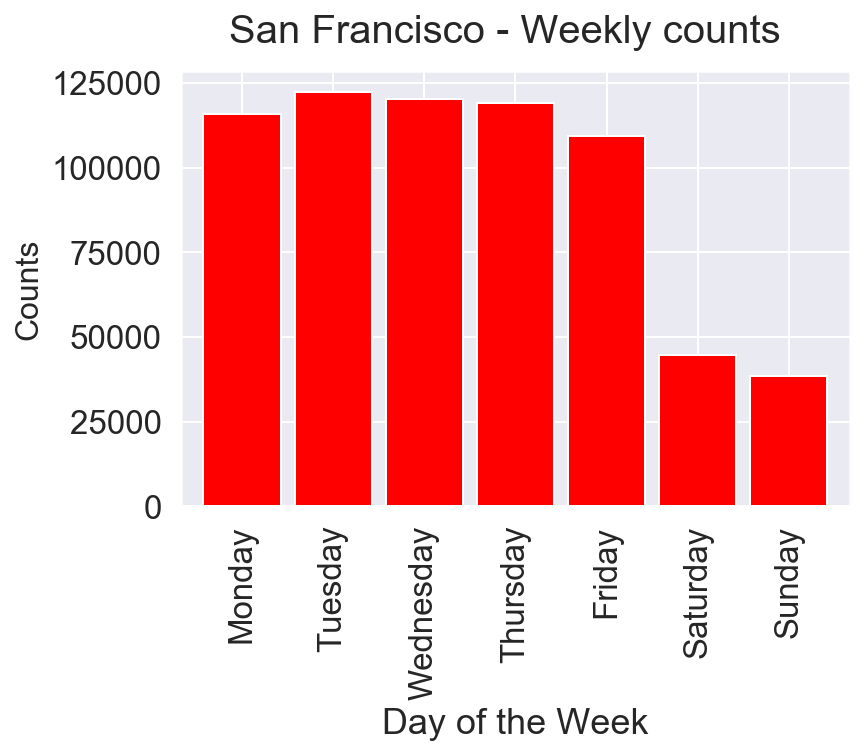

In [134]:
fig = plt.figure()
san_fran.groupby('Start_Day')['id'].count().plot(
    kind='bar', color='red', width=0.85)
fig.suptitle('San Francisco - Weekly counts', fontsize=20)
plt.xlabel('Day of the Week', fontsize=18)
plt.ylabel('Counts', fontsize=16)

# Los Angeles Data:

In [173]:
LA = pd.read_csv('/Users/vilvaki/Desktop/GA/bikes/los-angeles-metro-bike-share-trip-data/metro-bike-share-trip-data.csv')
# apo 7o tou 16 mexri dekemvri tou 16

In [174]:
LA.columns = [x.replace(' ','_') for x in LA.columns]

In [175]:
LA.head()

,Trip_ID,Duration,Start_Time,End_Time,Starting_Station_ID,Starting_Station_Latitude,Starting_Station_Longitude,Ending_Station_ID,Ending_Station_Latitude,Ending_Station_Longitude,...,Trip_Route_Category,Passholder_Type,Starting_Lat-Long,Ending_Lat-Long,Neighborhood_Councils_(Certified),Council_Districts,Zip_Codes,LA_Specific_Plans,Precinct_Boundaries,Census_Tracts
0,18222186,15060,2017-01-19T17:05:00.000,2017-01-19T21:16:00.000,3031.0,34.044701,-118.252441,3000.0,NaN,NaN,...,One Way,Walk-up,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9518671,77160,2016-10-09T14:37:00.000,2016-10-10T12:03:00.000,NaN,NaN,NaN,3000.0,NaN,NaN,...,One Way,Monthly Pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20444932,86400,2017-02-18T10:15:00.000,2017-02-20T15:20:00.000,3026.0,34.063179,-118.245880,3000.0,NaN,NaN,...,One Way,Walk-up,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20905031,18840,2017-02-27T12:26:00.000,2017-02-27T17:40:00.000,3023.0,34.050911,-118.240967,3000.0,NaN,NaN,...,One Way,Walk-up,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21031476,86400,2017-02-27T20:26:00.000,2017-03-01T09:49:00.000,3008.0,34.046612,-118.262733,3000.0,NaN,NaN,...,One Way,Flex Pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [176]:
LA.isnull().sum()

Trip_ID                                   0
Duration                                  0
Start_Time                                0
End_Time                                  0
Starting_Station_ID                      19
Starting_Station_Latitude                48
Starting_Station_Longitude               48
Ending_Station_ID                        96
Ending_Station_Latitude                1051
Ending_Station_Longitude               1051
Bike_ID                                  10
Plan_Duration                           766
Trip_Route_Category                       0
Passholder_Type                           0
Starting_Lat-Long                     33805
Ending_Lat-Long                        1051
Neighborhood_Councils_(Certified)     33837
Council_Districts                     33837
Zip_Codes                             33837
LA_Specific_Plans                    116624
Precinct_Boundaries                    1099
Census_Tracts                          1099
dtype: int64

In [177]:
LA.shape

(132427, 22)

In [178]:
LA.dropna().shape

(11785, 22)

In [179]:
LA.drop(columns=['LA_Specific_Plans'], inplace=True)

In [180]:
LA.shape

(132427, 21)

In [181]:
LA.dropna().shape

(97765, 21)

In [182]:
LA.dropna(inplace=True)

In [183]:
LA.shape

(97765, 21)

In [184]:
LA.head(2)

,Trip_ID,Duration,Start_Time,End_Time,Starting_Station_ID,Starting_Station_Latitude,Starting_Station_Longitude,Ending_Station_ID,Ending_Station_Latitude,Ending_Station_Longitude,...,Plan_Duration,Trip_Route_Category,Passholder_Type,Starting_Lat-Long,Ending_Lat-Long,Neighborhood_Councils_(Certified),Council_Districts,Zip_Codes,Precinct_Boundaries,Census_Tracts
2088,2023364,1980,2016-07-08T09:24:00.000,2016-07-08T09:57:00.000,3045.0,34.028511,-118.25667,3045.0,34.028511,-118.25667,...,30.0,Round Trip,Monthly Pass,"{'longitude': '-118.25667', 'latitude': '34.02...","{'longitude': '-118.25667', 'latitude': '34.02...",76.0,9.0,23082.0,1220.0,702.0
2090,2035311,780,2016-07-08T12:42:00.000,2016-07-08T12:55:00.000,3029.0,34.048851,-118.24642,3029.0,34.048851,-118.24642,...,0.0,Round Trip,Walk-up,"{'longitude': '-118.24642', 'latitude': '34.04...","{'longitude': '-118.24642', 'latitude': '34.04...",76.0,9.0,23074.0,1502.0,542.0


In [185]:
LA.Passholder_Type.value_counts()

Monthly Pass    60039
Walk-up         30531
Flex Pass        7195
Name: Passholder_Type, dtype: int64

In [186]:
LA.dtypes

Trip_ID                                int64
Duration                               int64
Start_Time                            object
End_Time                              object
Starting_Station_ID                  float64
Starting_Station_Latitude            float64
Starting_Station_Longitude           float64
Ending_Station_ID                    float64
Ending_Station_Latitude              float64
Ending_Station_Longitude             float64
Bike_ID                              float64
Plan_Duration                        float64
Trip_Route_Category                   object
Passholder_Type                       object
Starting_Lat-Long                     object
Ending_Lat-Long                       object
Neighborhood_Councils_(Certified)    float64
Council_Districts                    float64
Zip_Codes                            float64
Precinct_Boundaries                  float64
Census_Tracts                        float64
dtype: object

In [187]:
LA['Start_Time'] = pd.to_datetime(LA.Start_Time)
LA['End_Time'] = pd.to_datetime(LA.End_Time)

In [188]:
LA.dtypes

Trip_ID                                       int64
Duration                                      int64
Start_Time                           datetime64[ns]
End_Time                             datetime64[ns]
Starting_Station_ID                         float64
Starting_Station_Latitude                   float64
Starting_Station_Longitude                  float64
Ending_Station_ID                           float64
Ending_Station_Latitude                     float64
Ending_Station_Longitude                    float64
Bike_ID                                     float64
Plan_Duration                               float64
Trip_Route_Category                          object
Passholder_Type                              object
Starting_Lat-Long                            object
Ending_Lat-Long                              object
Neighborhood_Councils_(Certified)           float64
Council_Districts                           float64
Zip_Codes                                   float64
Precinct_Bou

In [189]:
LA['Start_Day'] = LA.Start_Time.dt.weekday_name
LA['End_Day'] = LA.End_Time.dt.weekday_name

In [190]:
# list(LA['Start_Day']) == list(LA['End_Day'])

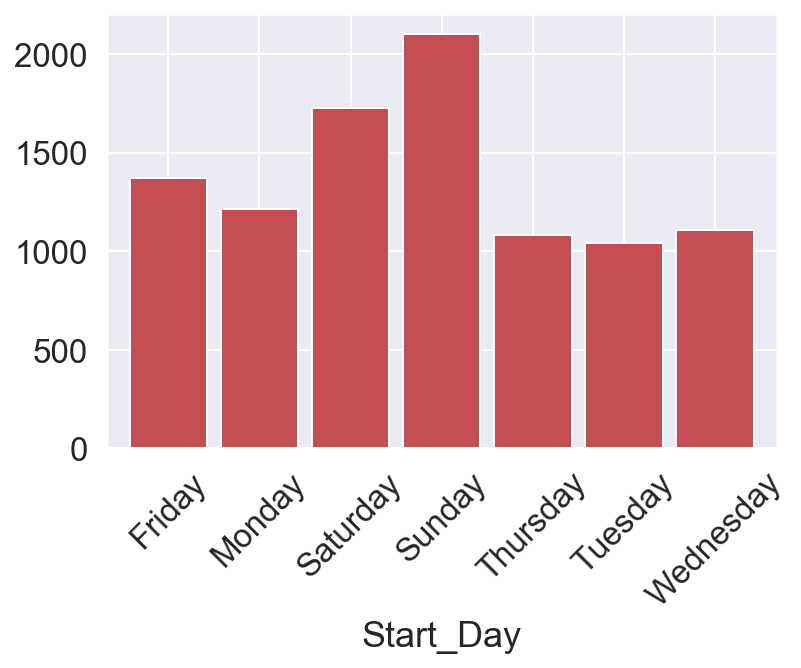

In [191]:
LA.groupby('Start_Day')['Duration'].mean().plot(
    kind='bar', color='r', width=0.85)
plt.xticks(rotation=45)
plt.show()

In [192]:
days_of_the_week = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# LA['Start_Day'] = LA['Start_Day'].astype('category', categories=cats, ordered=True)
LA['Start_Day'] = LA['Start_Day'].astype(CategoricalDtype(categories=days_of_the_week, ordered=True))


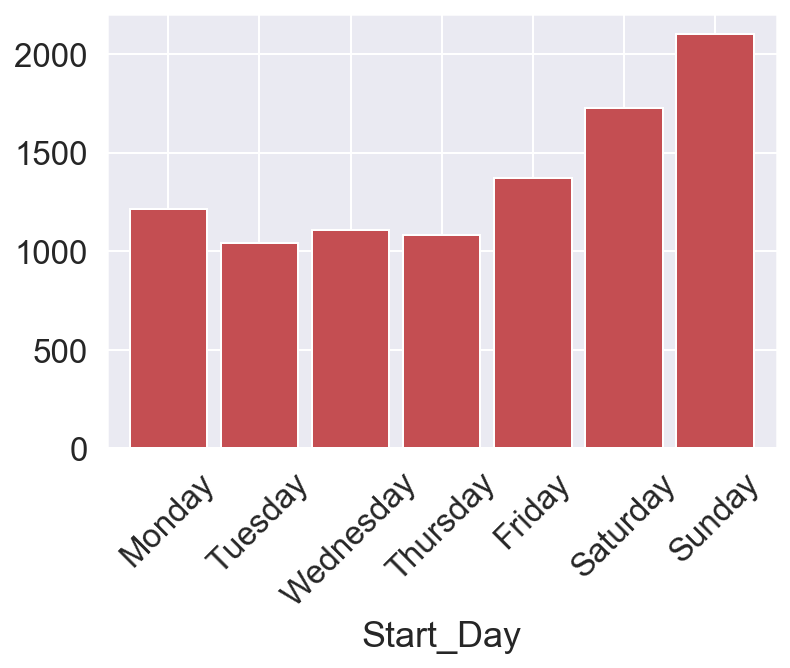

In [193]:
LA.groupby('Start_Day')['Duration'].mean().plot(
    kind='bar', color='r', width=0.85)
plt.xticks(rotation=45)
plt.show()

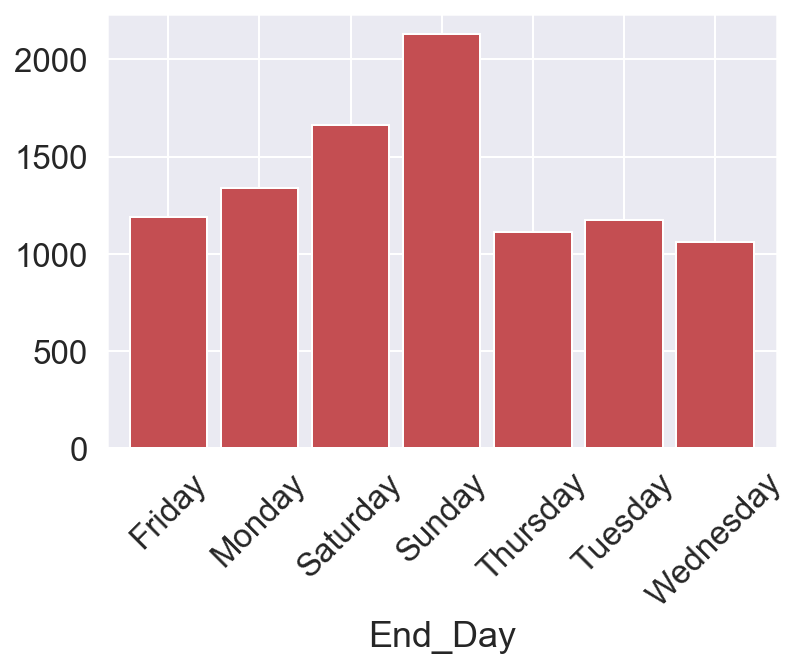

In [194]:
LA.groupby('End_Day')['Duration'].mean().plot(
    kind='bar', color='r', width=0.85)
plt.xticks(rotation=45)
plt.show()

In [195]:
LA['Month'] =  LA.Start_Time.dt.month_name()

In [196]:
LA['Month'].value_counts()

August       24140
September    19837
October      17863
November     14196
July         11402
December     10327
Name: Month, dtype: int64

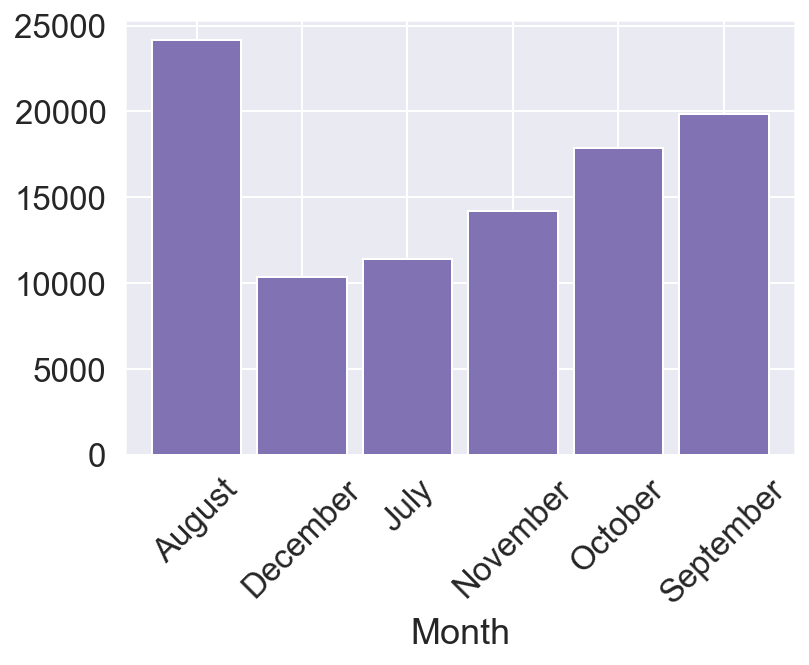

In [197]:
LA.groupby('Month')['Duration'].count().plot(
    kind='bar', color='m', width=0.85)
plt.xticks(rotation=45)
plt.show()

In [198]:
LA.Start_Time.max(), LA.Start_Time.min()

(Timestamp('2016-12-31 23:26:00'), Timestamp('2016-07-07 04:17:00'))

In [199]:
la_q1_17 = pd.read_csv('/Users/vilvaki/Desktop/GA/bikes/los-angeles-metro-bike-share-trip-data/la_metro_gbfs_trips_Q1_2017.zip')

In [200]:
LA.columns

Index(['Trip_ID', 'Duration', 'Start_Time', 'End_Time', 'Starting_Station_ID',
       'Starting_Station_Latitude', 'Starting_Station_Longitude',
       'Ending_Station_ID', 'Ending_Station_Latitude',
       'Ending_Station_Longitude', 'Bike_ID', 'Plan_Duration',
       'Trip_Route_Category', 'Passholder_Type', 'Starting_Lat-Long',
       'Ending_Lat-Long', 'Neighborhood_Councils_(Certified)',
       'Council_Districts', 'Zip_Codes', 'Precinct_Boundaries',
       'Census_Tracts', 'Start_Day', 'End_Day', 'Month'],
      dtype='object')

In [201]:
LA[['Starting_Lat-Long',
       'Ending_Lat-Long', 'Neighborhood_Councils_(Certified)',
       'Council_Districts', 'Zip_Codes', 'Precinct_Boundaries']]

,Starting_Lat-Long,Ending_Lat-Long,Neighborhood_Councils_(Certified),Council_Districts,Zip_Codes,Precinct_Boundaries
2088,"{'longitude': '-118.25667', 'latitude': '34.02...","{'longitude': '-118.25667', 'latitude': '34.02...",76.0,9.0,23082.0,1220.0
2090,"{'longitude': '-118.24642', 'latitude': '34.04...","{'longitude': '-118.24642', 'latitude': '34.04...",76.0,9.0,23074.0,1502.0
2091,"{'longitude': '-118.25667', 'latitude': '34.02...","{'longitude': '-118.25667', 'latitude': '34.02...",76.0,9.0,23082.0,1220.0
2092,"{'longitude': '-118.25667', 'latitude': '34.02...","{'longitude': '-118.25667', 'latitude': '34.02...",76.0,9.0,23082.0,1220.0
2094,"{'longitude': '-118.24588', 'latitude': '34.06...","{'longitude': '-118.24588', 'latitude': '34.06...",28.0,11.0,22728.0,449.0
...,...,...,...,...,...,...
132422,"{'longitude': '-118.26456', 'latitude': '34.05...","{'longitude': '-118.26456', 'latitude': '34.05...",76.0,11.0,23078.0,847.0
132423,"{'longitude': '-118.24716', 'latitude': '34.04...","{'longitude': '-118.27081', 'latitude': '34.03...",76.0,9.0,23074.0,660.0
132424,"{'longitude': '-118.23721', 'latitude': '34.05...","{'longitude': '-118.26709', 'latitude': '34.03...",28.0,9.0,22728.0,660.0
132425,"{'longitude': '-118.23253', 'latitude': '34.03...","{'longitude': '-118.25158', 'latitude': '34.04...",28.0,9.0,23074.0,527.0


In [ ]:
('/Users/vilvaki/Desktop/GA/bikes/los-angeles-metro-bike-share-trip-data/metro-bike-share-trips-2017-q3.csv'

In [202]:
la_q1_17.columns

Index(['trip_id', 'duration', 'start_time', 'end_time', 'start_station_id',
       'start_lat', 'start_lon', 'end_station_id', 'end_lat', 'end_lon',
       'bike_id', 'plan_duration', 'trip_route_category', 'passholder_type'],
      dtype='object')

In [203]:
la_q1_17.isnull().sum()

trip_id                  0
duration                 0
start_time               0
end_time                 0
start_station_id         0
start_lat               29
start_lon               29
end_station_id           0
end_lat                564
end_lon                564
bike_id                  0
plan_duration          384
trip_route_category      0
passholder_type          0
dtype: int64

In [204]:
la_q2_18 = pd.read_csv('/Users/vilvaki/Desktop/GA/bikes/los-angeles-metro-bike-share-trip-data/metro-bike-share-trips-2018-q2.csv.zip')

In [205]:
la_q2_18.columns

Index(['trip_id', 'duration', 'start_time', 'end_time', 'start_station',
       'start_lat', 'start_lon', 'end_station', 'end_lat', 'end_lon',
       'bike_id', 'plan_duration', 'trip_route_category', 'passholder_type'],
      dtype='object')

In [206]:
la_q2_18.isnull().sum()

trip_id                   0
duration                  0
start_time                0
end_time                  0
start_station             0
start_lat                87
start_lon                87
end_station               0
end_lat                1156
end_lon                1156
bike_id                   0
plan_duration             0
trip_route_category       0
passholder_type           0
dtype: int64

In [207]:
la_q2_18['start_time'] = pd.to_datetime(la_q2_18.start_time)
la_q2_18['start_time'] = pd.to_datetime(la_q2_18.start_time)

In [90]:
la_q2_18.groupby('start_time')['trip_id'].count()

start_time
2018-04-01 00:04:00    1
2018-04-01 00:09:00    1
2018-04-01 00:15:00    1
2018-04-01 00:28:00    1
2018-04-01 00:32:00    1
                      ..
2018-06-30 23:33:00    1
2018-06-30 23:40:00    1
2018-06-30 23:45:00    1
2018-06-30 23:49:00    1
2018-06-30 23:52:00    1
Name: trip_id, Length: 50050, dtype: int64

In [210]:
LA.Start_Time.max(), LA.Start_Time.min()

(Timestamp('2016-12-31 23:26:00'), Timestamp('2016-07-07 04:17:00'))

# Chicago:

In [69]:
Chicago = pd.read_csv('/Users/vilvaki/Desktop/GA/bikes/divvy-bike-chicago-2018/Divvy_Trips_2018_Q1.csv')

In [70]:
Chicago.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
0,17536702,2018-01-01 00:12:00,2018-01-01 00:17:23,3304,323.0,69,Damen Ave & Pierce Ave,159,Claremont Ave & Hirsch St,Subscriber,Male,1988.0
1,17536703,2018-01-01 00:41:35,2018-01-01 00:47:52,5367,377.0,253,Winthrop Ave & Lawrence Ave,325,Clark St & Winnemac Ave (Temp),Subscriber,Male,1984.0
2,17536704,2018-01-01 00:44:46,2018-01-01 01:33:10,4599,"2,904.0",98,LaSalle St & Washington St,509,Troy St & North Ave,Subscriber,Male,1989.0
3,17536705,2018-01-01 00:53:10,2018-01-01 01:05:37,2302,747.0,125,Rush St & Hubbard St,364,Larrabee St & Oak St,Subscriber,Male,1983.0
4,17536706,2018-01-01 00:53:37,2018-01-01 00:56:40,3696,183.0,129,Blue Island Ave & 18th St,205,Paulina St & 18th St,Subscriber,Male,1989.0


In [71]:
Chicago.shape

(387145, 12)

In [72]:
Chicago.isnull().sum()

trip_id                  0
start_time               0
end_time                 0
bikeid                   0
tripduration             0
from_station_id          0
from_station_name        0
to_station_id            0
to_station_name          0
usertype                 0
gender               22493
birthyear            22322
dtype: int64

In [73]:
Chicago.dropna(inplace=True)

In [74]:
Chicago.shape

(364648, 12)

In [75]:
Chicago.dtypes

trip_id                int64
start_time            object
end_time              object
bikeid                 int64
tripduration          object
from_station_id        int64
from_station_name     object
to_station_id          int64
to_station_name       object
usertype              object
gender                object
birthyear            float64
dtype: object

In [76]:
Chicago.gender
Chicago.groupby('gender')['tripduration'].count()

gender
Female     71072
Male      293576
Name: tripduration, dtype: int64

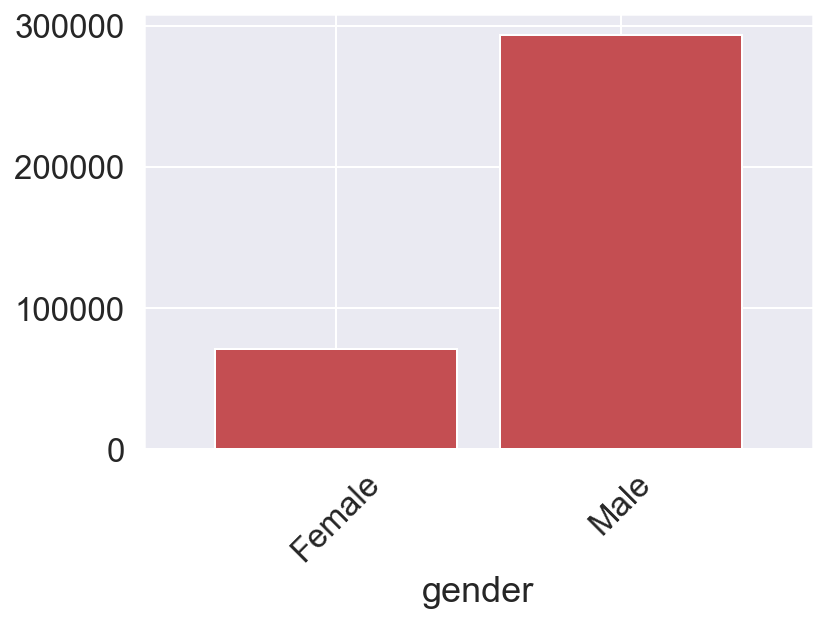

In [77]:
Chicago.groupby('gender')['tripduration'].count().plot(
    kind='bar', color='r', width=0.85)
plt.xticks(rotation=45)
plt.show()

In [78]:
# plt.hist(Chicago.from_station_name, bins=len(Chicago.from_station_name))
# plt.xticks(rotation='vertical')
# plt.show()

In [79]:
Chicago.tripduration = [float(x.replace(',','')) for x in Chicago.tripduration]

In [80]:
Chicago.tripduration.dtypes

dtype('float64')

In [81]:
Chicago['start_time'] = pd.to_datetime(Chicago.start_time)
Chicago['end_time'] = pd.to_datetime(Chicago.end_time)

In [82]:
Chicago['Start_Day'] = Chicago.start_time.dt.weekday_name
Chicago['End_Day'] = Chicago.end_time.dt.weekday_name

In [83]:
Chicago.head(2)

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,Start_Day,End_Day
0,17536702,2018-01-01 00:12:00,2018-01-01 00:17:23,3304,323.0,69,Damen Ave & Pierce Ave,159,Claremont Ave & Hirsch St,Subscriber,Male,1988.0,Monday,Monday
1,17536703,2018-01-01 00:41:35,2018-01-01 00:47:52,5367,377.0,253,Winthrop Ave & Lawrence Ave,325,Clark St & Winnemac Ave (Temp),Subscriber,Male,1984.0,Monday,Monday


In [84]:
Chicago.bikeid.count()

364648

In [85]:
Chicago.columns

Index(['trip_id', 'start_time', 'end_time', 'bikeid', 'tripduration',
       'from_station_id', 'from_station_name', 'to_station_id',
       'to_station_name', 'usertype', 'gender', 'birthyear', 'Start_Day',
       'End_Day'],
      dtype='object')

In [86]:
Chicago.usertype.value_counts()

Subscriber    364542
Customer         106
Name: usertype, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

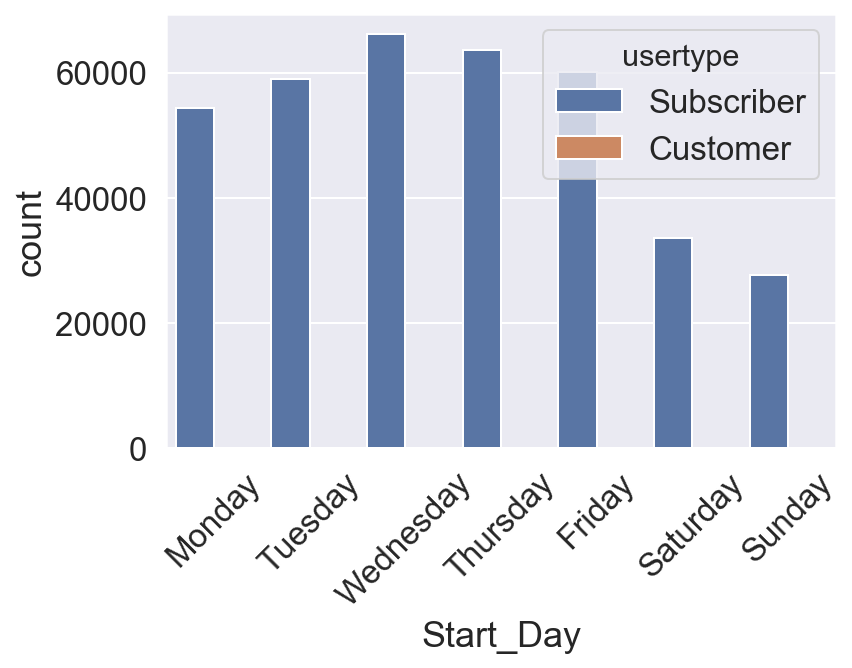

In [87]:
sns.countplot(x='Start_Day', hue='usertype', data=Chicago);
plt.xticks(rotation=45)

In [93]:
days_of_the_week = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]

In [94]:
Chicago['Start_Day'] = Chicago['Start_Day'].astype(CategoricalDtype(categories=days_of_the_week, ordered=True))

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

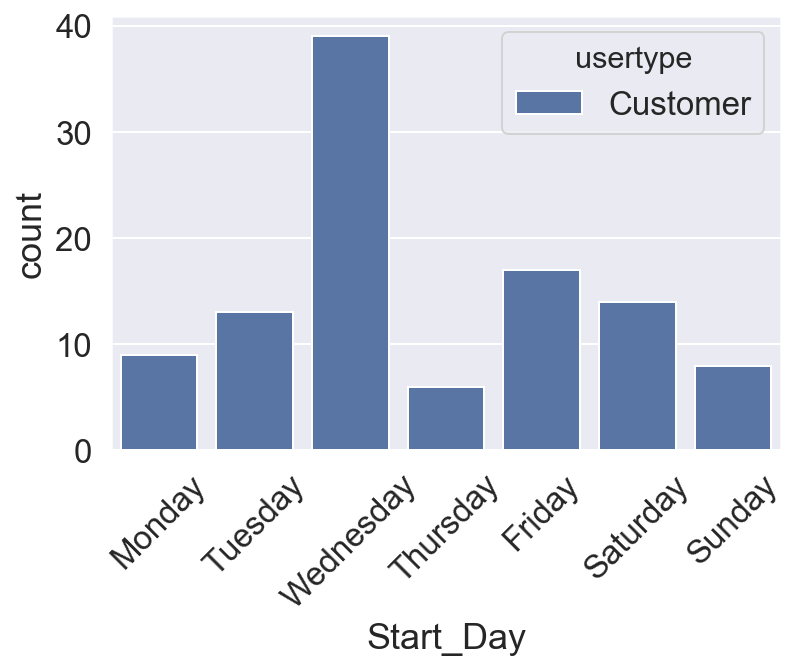

In [95]:
sns.countplot(x='Start_Day', hue='usertype', data=Chicago[Chicago.usertype =='Customer']);
plt.xticks(rotation=45)

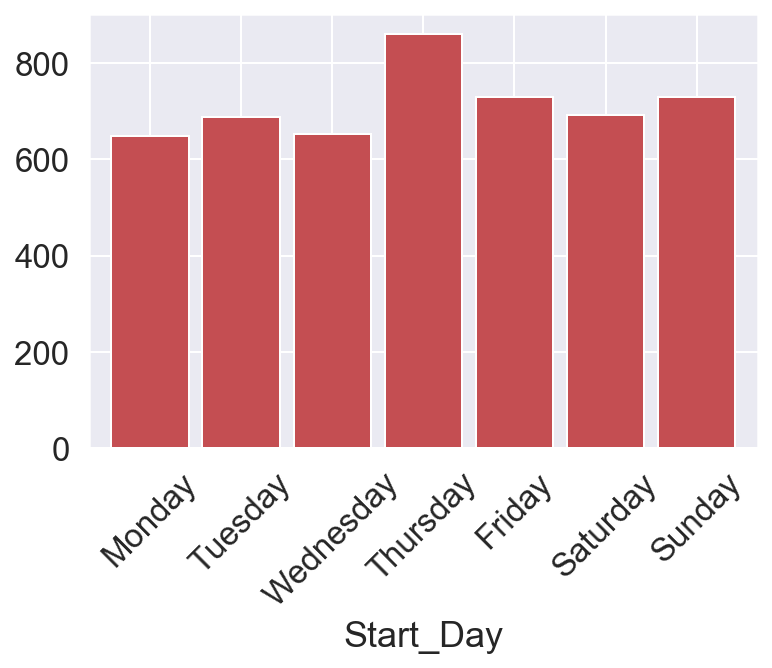

In [96]:
Chicago.groupby('Start_Day')['tripduration'].mean().plot(
    kind='bar', color='r', width=0.85)
plt.xticks(rotation=45)
plt.show()

In [97]:
Chicago['Month'] =  Chicago.start_time.dt.month_name()

In [98]:
Chicago['Month'].value_counts()

March       158901
January     106197
February     99550
Name: Month, dtype: int64

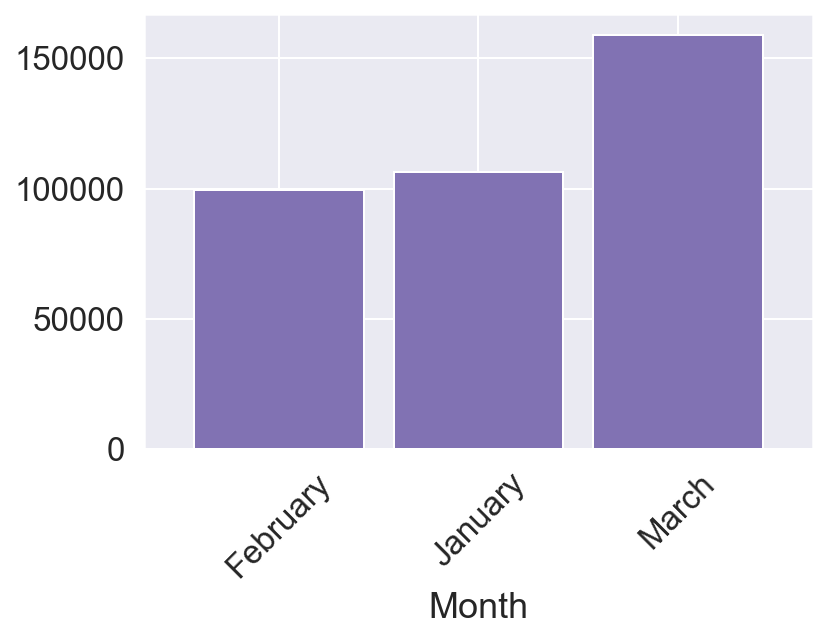

In [99]:
Chicago.groupby('Month')['tripduration'].count().plot(
    kind='bar', color='m', width=0.85)
plt.xticks(rotation=45)
plt.show()

In [100]:
Chicago.start_time.max() , Chicago.start_time.min()

(Timestamp('2018-03-31 23:53:38'), Timestamp('2018-01-01 00:12:00'))

Text(0, 0.5, 'Counts')

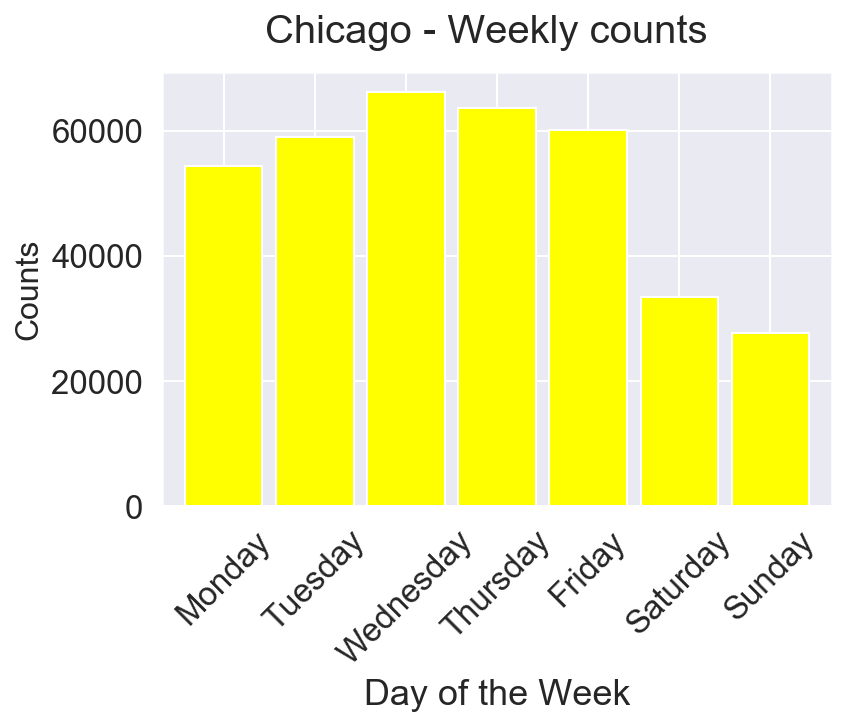

In [132]:
fig = plt.figure()
Chicago.groupby('Start_Day')['tripduration'].count().plot(
    kind='bar', color='yellow', width=0.85)
fig.suptitle('Chicago - Weekly counts', fontsize=20)
plt.xlabel('Day of the Week', fontsize=18)
plt.xticks(rotation=45)
plt.ylabel('Counts', fontsize=16)

# Total bikes each day - all cities:

In [239]:
total_duration_san_fran = sf.groupby('Start_Day')['duration'].mean()
# total_london = London.groupby('Day')['cnt'].mean()
total_duration_la = LA.groupby('Start_Day')['Duration'].mean()
total_duration_chicago = Chicago.groupby('Start_Day')['tripduration'].mean()

In [240]:
total_duration_san_fran

Start_Day
Monday        852.989031
Tuesday       812.092819
Wednesday     833.807988
Thursday      874.311851
Friday       1043.918215
Saturday     2387.528281
Sunday       2509.360094
Name: duration, dtype: float64

In [241]:
type(total_duration_chicago)

pandas.core.series.Series

In [242]:
df = pd.DataFrame({'duration_san_fran': total_duration_san_fran, \
                   'duration_la': total_duration_la, 'duration_chicago':total_duration_chicago })

In [243]:
df

,duration_san_fran,duration_la,duration_chicago
Start_Day,,,
Monday,852.989031,1214.698758,647.011686
Tuesday,812.092819,1043.536637,687.709540
Wednesday,833.807988,1109.492940,652.495080
Thursday,874.311851,1080.555372,858.891019
Friday,1043.918215,1370.300066,729.175379
Saturday,2387.528281,1727.767251,692.030413
Sunday,2509.360094,2100.357227,728.074940


In [244]:
list_of_index_days = df.index
list_of_index_days

CategoricalIndex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                  'Saturday', 'Sunday'],
                 categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True, name='Start_Day', dtype='category')

In [245]:
df['Day'] = list_of_index_days
df

,duration_san_fran,duration_la,duration_chicago,Day
Start_Day,,,,
Monday,852.989031,1214.698758,647.011686,Monday
Tuesday,812.092819,1043.536637,687.709540,Tuesday
Wednesday,833.807988,1109.492940,652.495080,Wednesday
Thursday,874.311851,1080.555372,858.891019,Thursday
Friday,1043.918215,1370.300066,729.175379,Friday
Saturday,2387.528281,1727.767251,692.030413,Saturday
Sunday,2509.360094,2100.357227,728.074940,Sunday


In [248]:
df['Day']= df['Day'].astype(CategoricalDtype(categories=days_of_the_week, ordered=True))


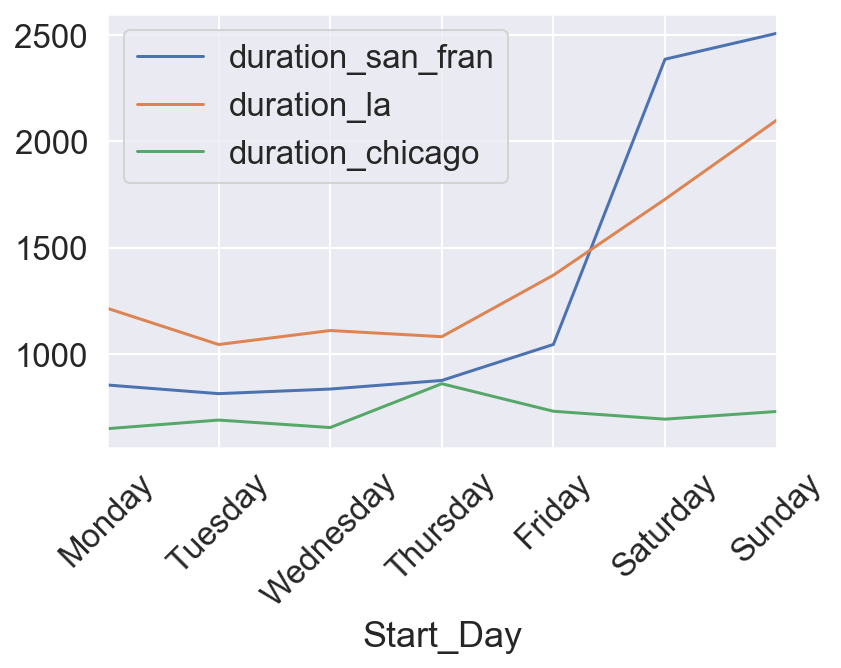

In [249]:
df.plot.line()
plt.xticks(rotation=45)
plt.show()

In [251]:
count_san_fran = sf.groupby('Start_Day')['duration'].count()
# count_london = London.groupby('Day')['cnt'].count()
count_la = LA.groupby('Start_Day')['Duration'].count()
count_chicago = Chicago.groupby('Start_Day')['tripduration'].count()

In [252]:
sf.shape[0]

669955

In [254]:
all_counts = pd.DataFrame({'Days':days_of_the_week, 'count_san_fran':sf.shape[0]/count_san_fran, \
#                            'count_london':London.shape[0]/count_london,\
                           'count_la':LA.shape[0]/count_la,\
                           'count_chicago':Chicago.shape[0]/count_chicago})

In [255]:
all_counts.dtypes

Days               object
count_san_fran    float64
count_la          float64
count_chicago     float64
dtype: object

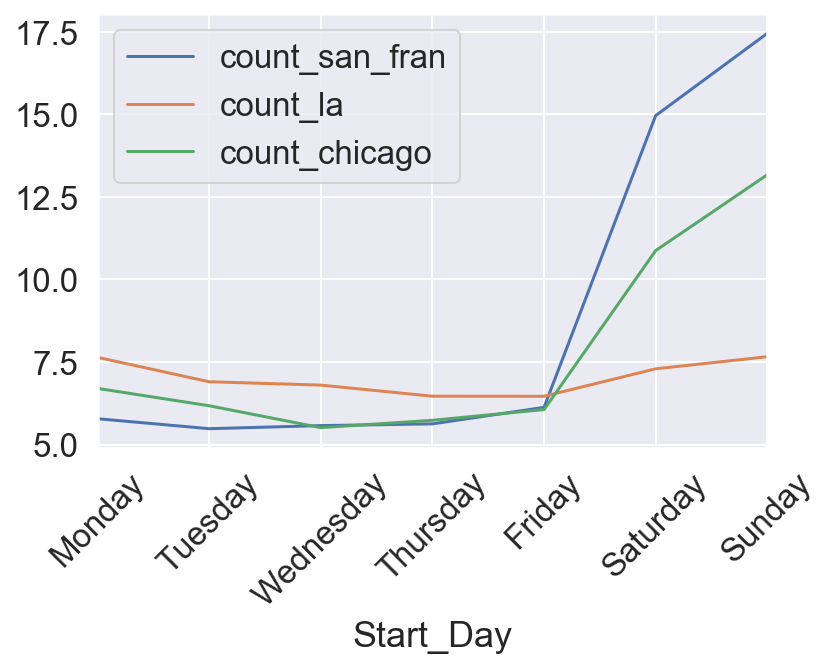

In [256]:
all_counts.plot.line()
plt.xticks(rotation=45)
plt.show()

In [257]:
scaler = StandardScaler()

In [258]:
# all_counts_std = pd.DataFrame(scaler.fit_transform(all_counts[['count_san_fran','count_london','count_la','count_chicago']]),columns=['count_san_fran','count_london','count_la','count_chicago'])
all_counts_std = pd.DataFrame(scaler.fit_transform(all_counts[['count_san_fran','count_la','count_chicago']]),columns=['count_san_fran','count_la','count_chicago'])


In [260]:
# all_counts_std.set_index(days)
all_counts_std.index = days_of_the_week

In [261]:
all_counts_std

,count_san_fran,count_la,count_chicago
Monday,-0.612353,1.293284,-0.374287
Tuesday,-0.675421,-0.276003,-0.562720
Wednesday,-0.655828,-0.491291,-0.799660
Thursday,-0.644959,-1.206104,-0.719929
Friday,-0.540443,-1.210645,-0.603805
Saturday,1.304372,0.556767,1.119172
Sunday,1.824632,1.333992,1.941230


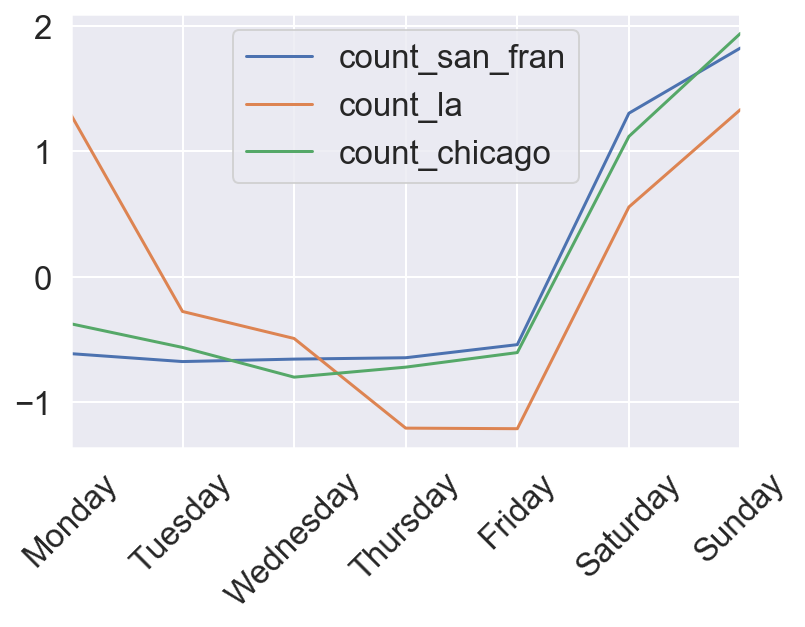

In [262]:
all_counts_std.plot.line()
plt.xticks(rotation=45)
plt.show()

# Austin:

In [102]:
austin = pd.read_csv('/Users/vilvaki/Desktop/GA/bikes/austin-bike/austin_bikeshare_trips.csv')

In [103]:
austin.shape

(649231, 12)

In [104]:
austin.start_time.value_counts()

2015-03-19 18:12:00    304
2015-03-19 15:12:00    293
2014-03-15 17:12:00    289
2015-03-15 15:12:00    286
2015-03-14 15:12:00    277
                      ... 
2016-03-20 11:12:01      1
2016-07-12 20:45:47      1
2017-01-29 18:15:12      1
2016-09-11 22:22:49      1
2016-11-15 17:12:54      1
Name: start_time, Length: 357010, dtype: int64

In [105]:
austin.isnull().sum()

bikeid                  723
checkout_time             0
duration_minutes          0
end_station_id        19842
end_station_name          0
month                 30752
start_station_id      19041
start_station_name        0
start_time                0
subscriber_type        2077
trip_id                   0
year                  30752
dtype: int64

In [106]:
austin.drop(columns=['start_station_id','end_station_id','month','year'], inplace=True)

In [107]:
austin.isnull().sum()

bikeid                 723
checkout_time            0
duration_minutes         0
end_station_name         0
start_station_name       0
start_time               0
subscriber_type       2077
trip_id                  0
dtype: int64

In [108]:
austin.shape

(649231, 8)

In [109]:
austin.dropna(inplace=True)

In [110]:
austin.shape

(646431, 8)

In [111]:
austin.head()

,bikeid,checkout_time,duration_minutes,end_station_name,start_station_name,start_time,subscriber_type,trip_id
0,8.0,19:12:00,41,Trinity & 6th Street,Waller & 6th St.,2015-03-19 19:12:00,Walk Up,9900082882
1,141.0,2:06:04,6,South Congress & Academy,2nd & Congress,2016-10-30 02:06:04,Local365,12617682
2,578.0,16:28:27,13,Convention Center / 4th St. @ MetroRail,Bullock Museum @ Congress & MLK,2016-03-11 16:28:27,Local365,9075366
3,555.0,15:12:00,80,Toomey Rd @ South Lamar,Capitol Station / Congress & 11th,2014-11-23 15:12:00,24-Hour Kiosk (Austin B-cycle),9900319298
4,86.0,15:39:13,25,MoPac Pedestrian Bridge @ Veterans Drive,Rainey St @ Cummings,2017-04-16 15:39:13,Walk Up,14468597


In [112]:
austin.dtypes

bikeid                float64
checkout_time          object
duration_minutes        int64
end_station_name       object
start_station_name     object
start_time             object
subscriber_type        object
trip_id                 int64
dtype: object

In [113]:
austin['start_time'] = pd.to_datetime(austin.start_time)

In [114]:
austin['Start_Day'] = austin.start_time.dt.weekday_name

In [115]:
austin.head()

,bikeid,checkout_time,duration_minutes,end_station_name,start_station_name,start_time,subscriber_type,trip_id,Start_Day
0,8.0,19:12:00,41,Trinity & 6th Street,Waller & 6th St.,2015-03-19 19:12:00,Walk Up,9900082882,Thursday
1,141.0,2:06:04,6,South Congress & Academy,2nd & Congress,2016-10-30 02:06:04,Local365,12617682,Sunday
2,578.0,16:28:27,13,Convention Center / 4th St. @ MetroRail,Bullock Museum @ Congress & MLK,2016-03-11 16:28:27,Local365,9075366,Friday
3,555.0,15:12:00,80,Toomey Rd @ South Lamar,Capitol Station / Congress & 11th,2014-11-23 15:12:00,24-Hour Kiosk (Austin B-cycle),9900319298,Sunday
4,86.0,15:39:13,25,MoPac Pedestrian Bridge @ Veterans Drive,Rainey St @ Cummings,2017-04-16 15:39:13,Walk Up,14468597,Sunday


In [116]:
austin.dtypes

bikeid                       float64
checkout_time                 object
duration_minutes               int64
end_station_name              object
start_station_name            object
start_time            datetime64[ns]
subscriber_type               object
trip_id                        int64
Start_Day                     object
dtype: object

In [123]:
austin['Start_Day'] = austin['Start_Day'].astype(CategoricalDtype(categories=days_of_the_week, ordered=True))

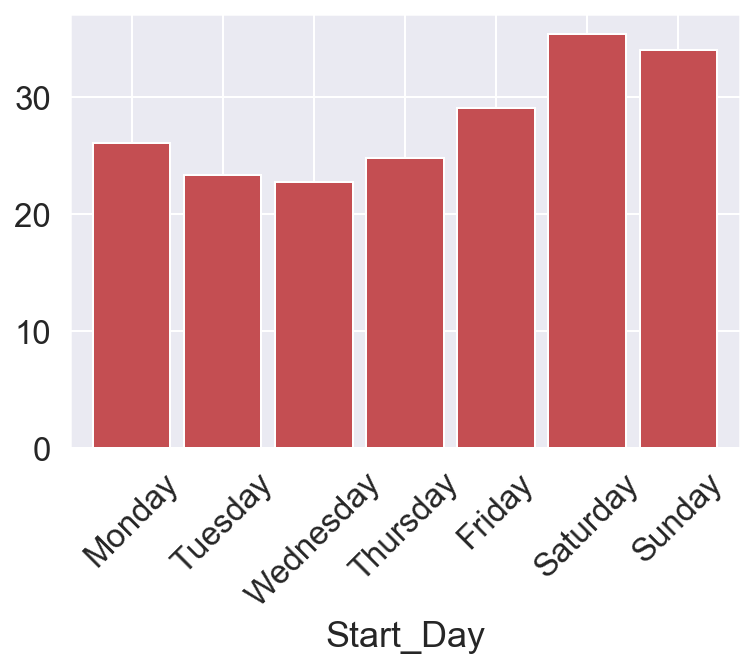

In [124]:
austin.groupby('Start_Day')['duration_minutes'].mean().plot(
    kind='bar', color='r', width=0.85)
plt.xticks(rotation=45)
plt.show()

In [125]:
austin['Month'] = austin.start_time.dt.month_name()


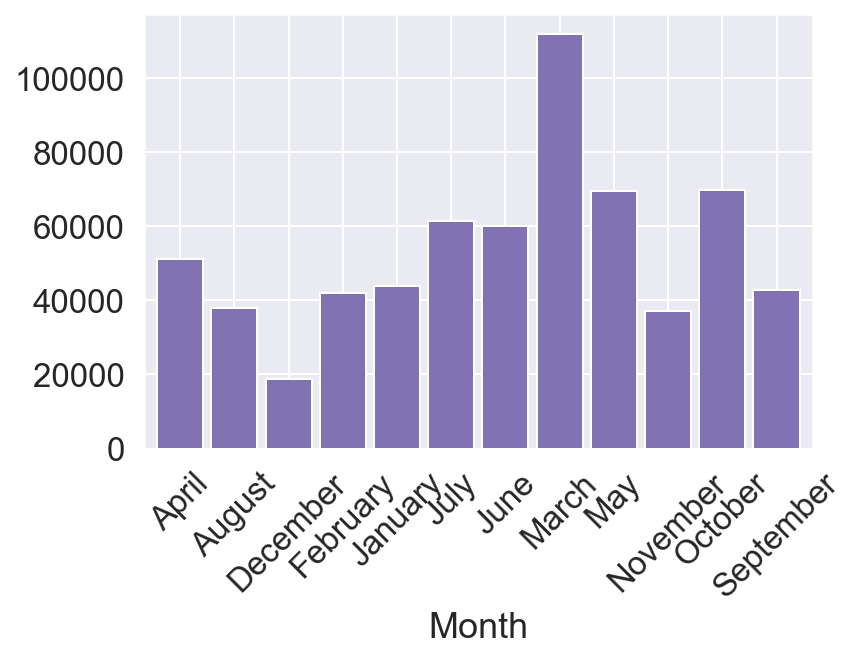

In [126]:
austin.groupby('Month')['duration_minutes'].count().plot(
    kind='bar', color='m', width=0.85)
plt.xticks(rotation=45)
plt.show()


In [127]:
austin.columns

Index(['bikeid', 'checkout_time', 'duration_minutes', 'end_station_name',
       'start_station_name', 'start_time', 'subscriber_type', 'trip_id',
       'Start_Day', 'Month'],
      dtype='object')

In [128]:
austin.start_time.max() , austin.start_time.min()

(Timestamp('2017-07-31 23:44:27'), Timestamp('2013-12-21 09:12:00'))

Text(0, 0.5, 'Counts')

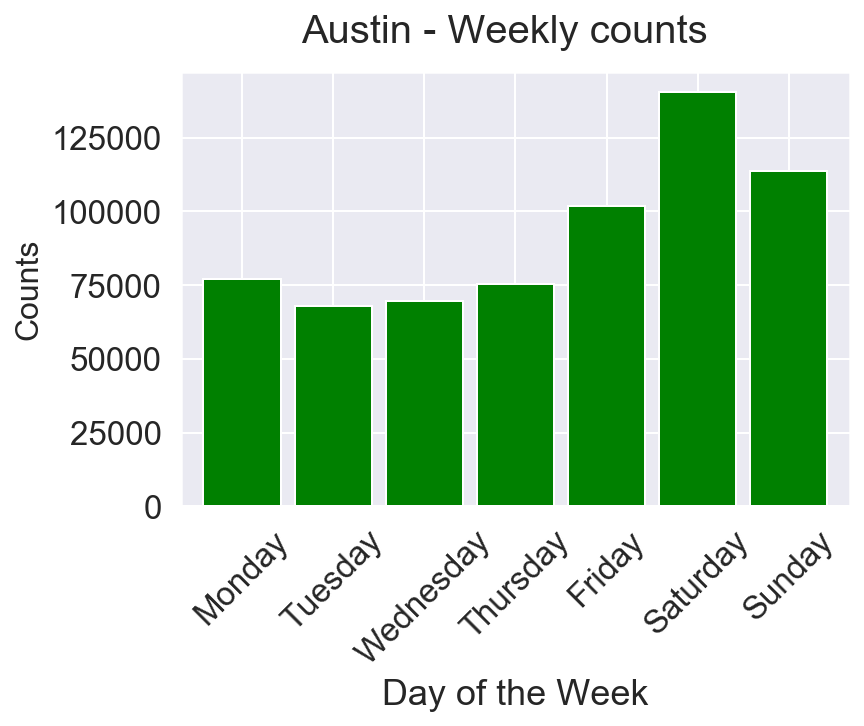

In [133]:
fig = plt.figure()
austin.groupby('Start_Day')['duration_minutes'].count().plot(
    kind='bar', color='green', width=0.85)
fig.suptitle('Austin - Weekly counts', fontsize=20)
plt.xlabel('Day of the Week', fontsize=18)
plt.xticks(rotation=45)
plt.ylabel('Counts', fontsize=16)

# ===================

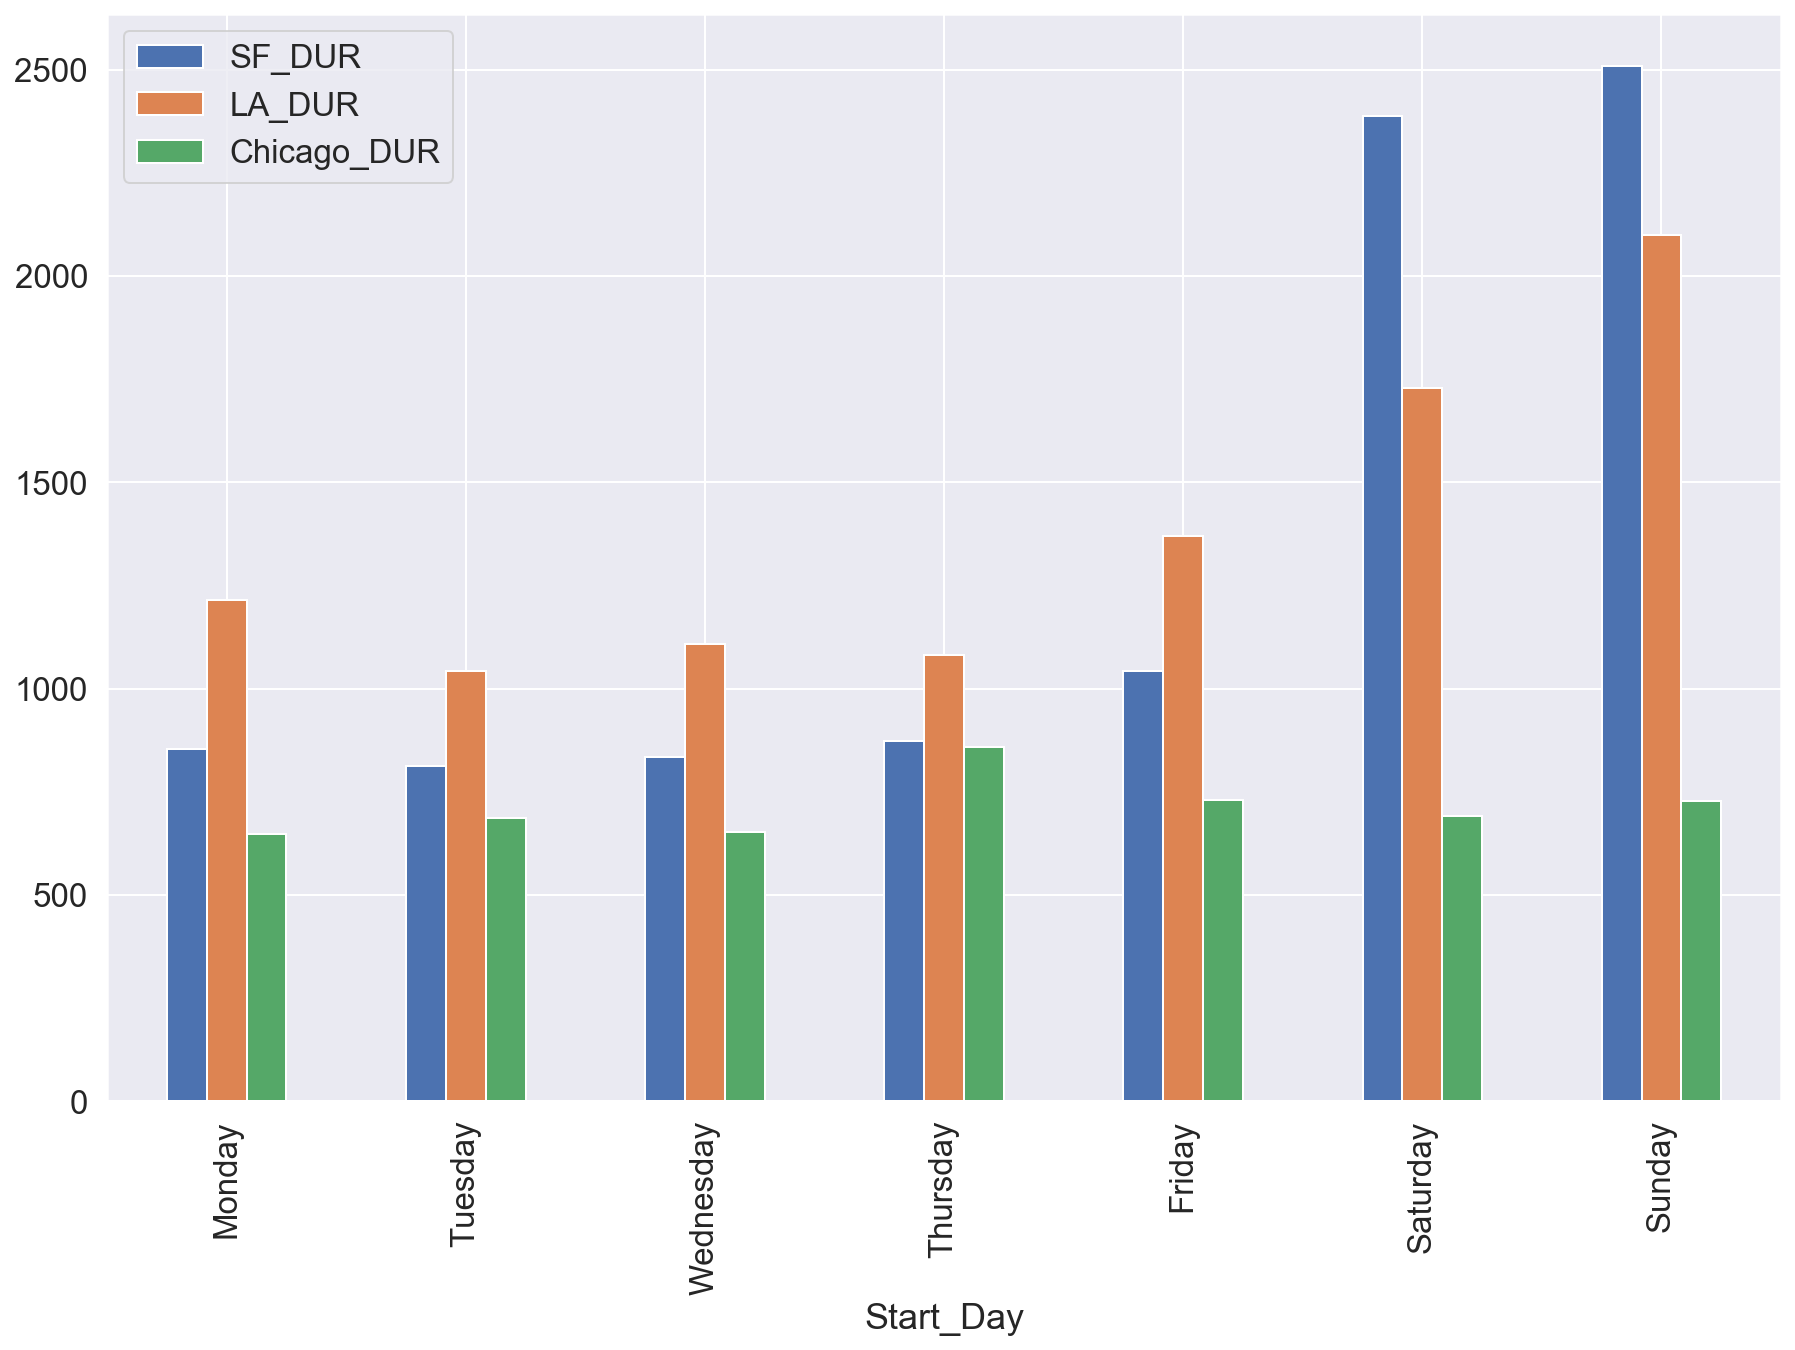

In [281]:
# columns=['SF', 'LA', 'CHICAGO', 'LONDON', 'CANADA', 'DC']
DF_ALL = pd.DataFrame({'SF_DUR':sf.groupby('Start_Day')['duration'].mean(),\
                       'LA_DUR':LA.groupby('Start_Day')['Duration'].mean(),\
                      'Chicago_DUR':Chicago.groupby('Start_Day')['tripduration'].mean()})

DF_ALL.plot.bar( figsize=(15,10));

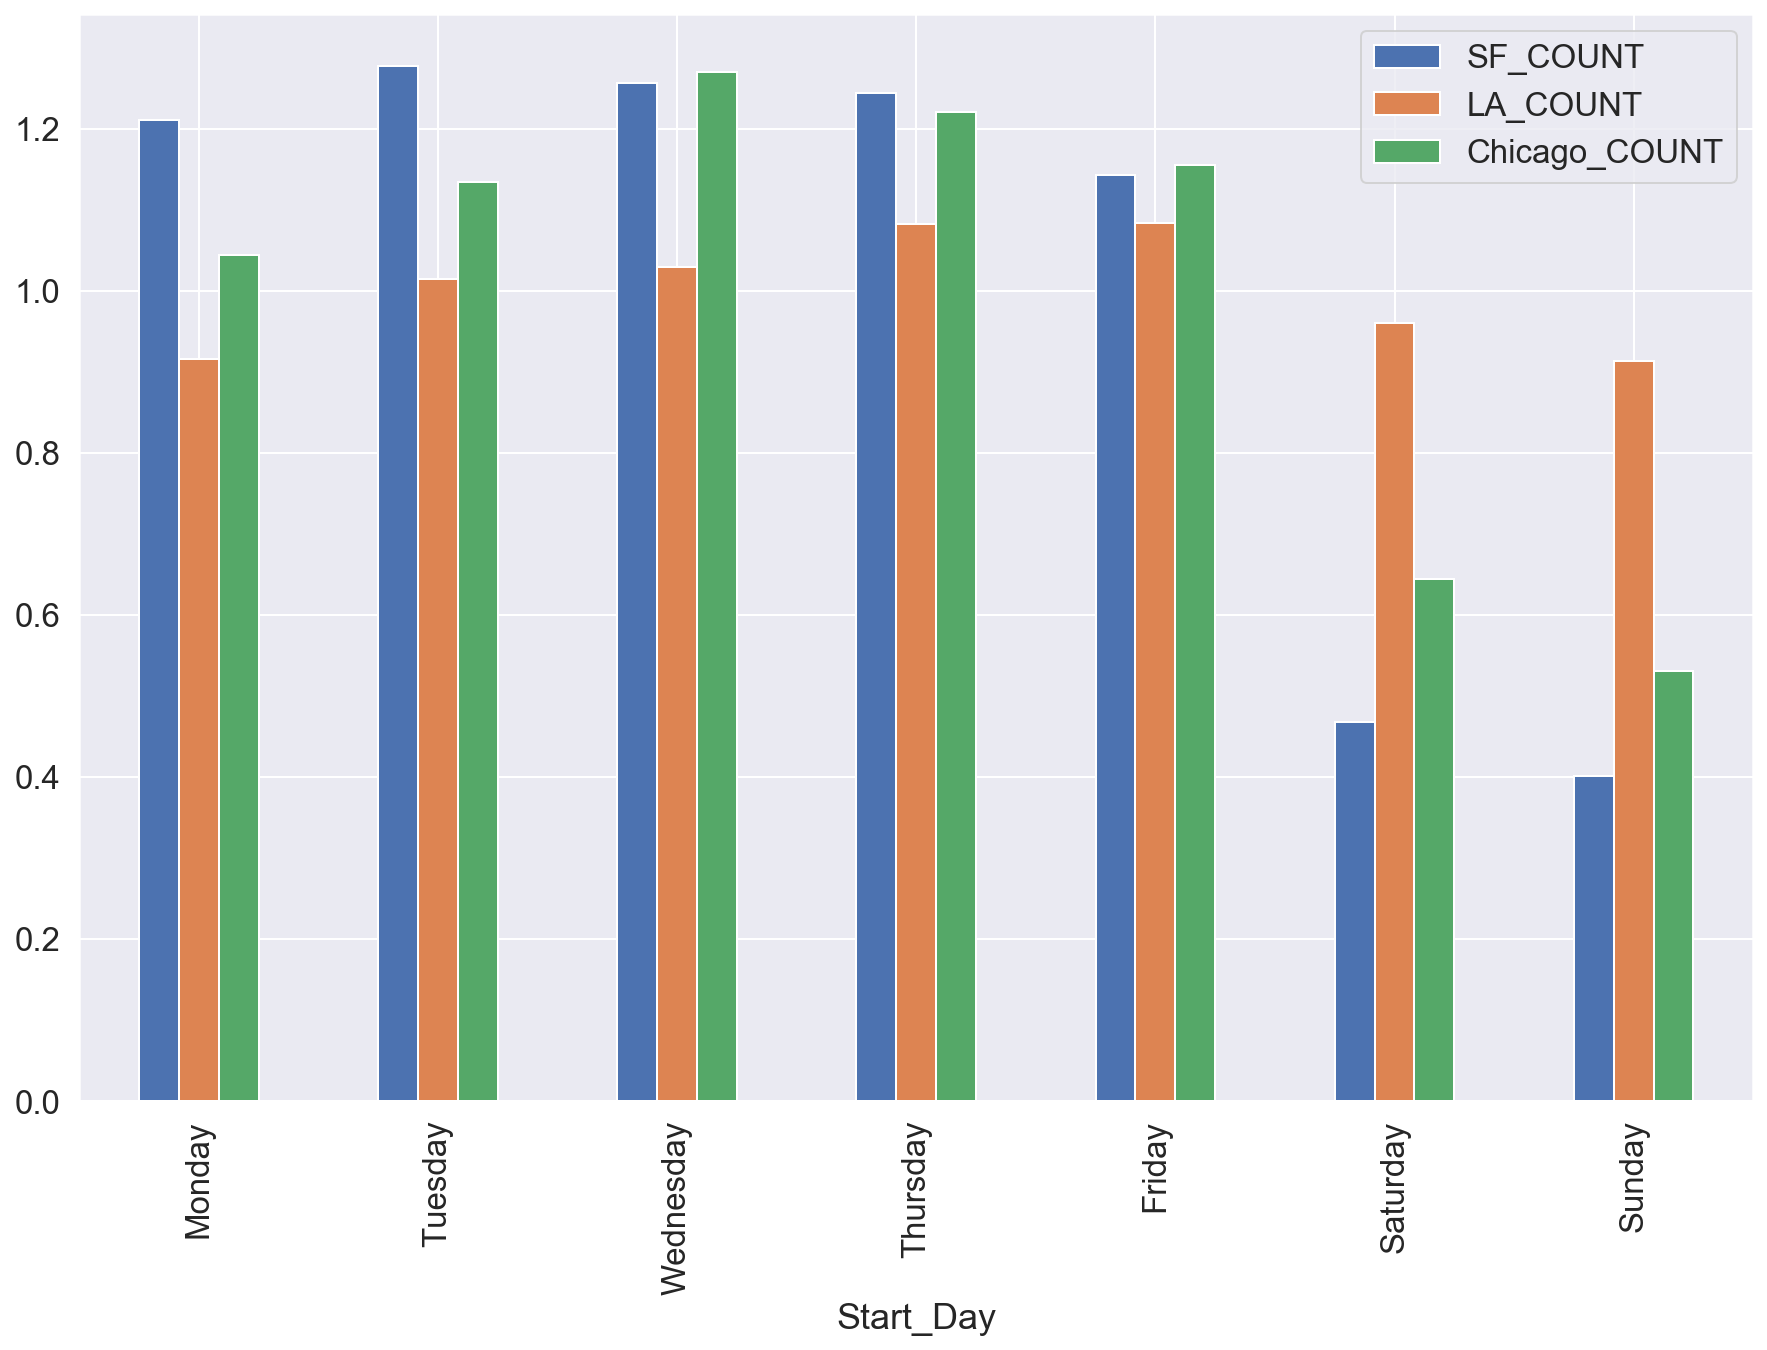

In [282]:
df_count = pd.DataFrame({'SF_COUNT':sf.groupby('Start_Day')['duration'].count()/sf.groupby('Start_Day')['duration'].count().mean(),
'LA_COUNT':LA.groupby('Start_Day')['Duration'].count()/LA.groupby('Start_Day')['Duration'].count().mean(),\
'Chicago_COUNT':Chicago.groupby('Start_Day')['tripduration'].count()/Chicago.groupby('Start_Day')['tripduration'].count().mean()})

                    
df_count.plot.bar( figsize=(15,10));

# SUBSCRIPTION TYPE:

In [157]:
LA.Passholder_Type.value_counts()

Monthly Pass    60039
Walk-up         30531
Flex Pass        7195
Name: Passholder_Type, dtype: int64

In [158]:
# LA:
# Monthly Pass =>Subscriber
# Walk-up + Flex Pass => Customer
subsctiption_la = []
for val in LA.Passholder_Type:
    if val == 'Monthly Pass':
        subsctiption_la.append('Subscriber')
    else:
        subsctiption_la.append('Customer')
        
LA['Passholder_Type_new']= subsctiption_la

In [159]:
LA.Passholder_Type_new.value_counts()

Subscriber    60039
Customer      37726
Name: Passholder_Type_new, dtype: int64

In [160]:
LA.Passholder_Type_new

2088      Subscriber
2090        Customer
2091      Subscriber
2092      Subscriber
2094        Customer
             ...    
132422      Customer
132423    Subscriber
132424    Subscriber
132425      Customer
132426    Subscriber
Name: Passholder_Type_new, Length: 97765, dtype: object

In [161]:
sf.subscription_type.value_counts()

Subscriber    566745
Customer      103210
Name: subscription_type, dtype: int64

In [305]:
Chicago.usertype.value_counts()

Subscriber    364542
Customer         106
Name: usertype, dtype: int64

In [163]:
Subscriber_austin = ['Local365','Local30','Annual Membership (Austin B-cycle)'\
                     ,'Local365 ($80 plus tax)','Founding Member','Founding Member (Austin B-cycle)'\
                     ,'7-Day Membership (Austin B-cycle)','Local365+Guest Pass','Semester Membership (Austin B-cycle)'\
                     ,'Semester Membership','Local30 ($11 plus tax)','Annual','Weekender ($15 plus tax)'\
                     ,'Annual (San Antonio B-cycle)','Annual Membership','Annual Member',\
                     'Annual Member (Houston B-cycle)','Annual Membership (Fort Worth Bike Sharing)'\
                     ,'Annual (Denver B-cycle)','Annual (Madison B-cycle)','Annual (Broward B-cycle)'\
                     ,'Annual Plus','Annual (Denver Bike Sharing)','Annual (Boulder B-cycle)'\
                     ,'Local365 Youth with helmet (age 13-17 riders)','Republic Rider (Annual)'\
                     ,'Annual Membership (GREENbike)','Annual (Kansas City B-cycle)','Annual (Cincy Red Bike)'\
                     ,'Annual (Nashville B-cycle)','Annual Membership (Charlotte B-cycle)','Annual Pass'\
                     ,'Membership: pay once  one-year commitment','Denver B-cycle Founder'\
                     ,'Annual Membership (Indy - Pacers Bikeshare )','Local365 Youth (age 13-17 riders)'\
                     ,'Annual (Omaha B-cycle)']

subsctiption_austin=[]
for val in austin.subscriber_type:
    if val in Subscriber_austin:
        subsctiption_austin.append('Subscriber')
    else:
        subsctiption_austin.append('Customer')
        
austin['subscriber_type_new']= subsctiption_austin

In [164]:
austin.subscriber_type_new.value_counts()

Customer      428572
Subscriber    217859
Name: subscriber_type_new, dtype: int64

In [165]:
austin.subscriber_type.value_counts()

Walk Up                                          281915
Local365                                         126426
24-Hour Kiosk (Austin B-cycle)                   108467
Local30                                           37017
Annual Membership (Austin B-cycle)                30243
Weekender                                         24595
Explorer                                           8240
Local365 ($80 plus tax)                            4004
Founding Member                                    3547
7-Day                                              3124
Founding Member (Austin B-cycle)                   2763
7-Day Membership (Austin B-cycle)                  2752
Local365+Guest Pass                                2567
Semester Membership (Austin B-cycle)               2418
Semester Membership                                 900
Local30 ($11 plus tax)                              840
Annual                                              797
24-Hour-Online (Austin B-cycle)                 

In [166]:
len(Subscriber_austin)

37

In [167]:
LA_sub = LA.groupby(['Start_Day','Passholder_Type_new'])['Passholder_Type_new'].count()
SF_sub = sf.groupby(['Start_Day','subscription_type'])['subscription_type'].count()
# Chicago_sub = Chicago.groupby(['Start_Day','usertype'])['usertype'].count()
austin_sub = austin.groupby(['Start_Day','subscriber_type_new'])['subscriber_type_new'].count()

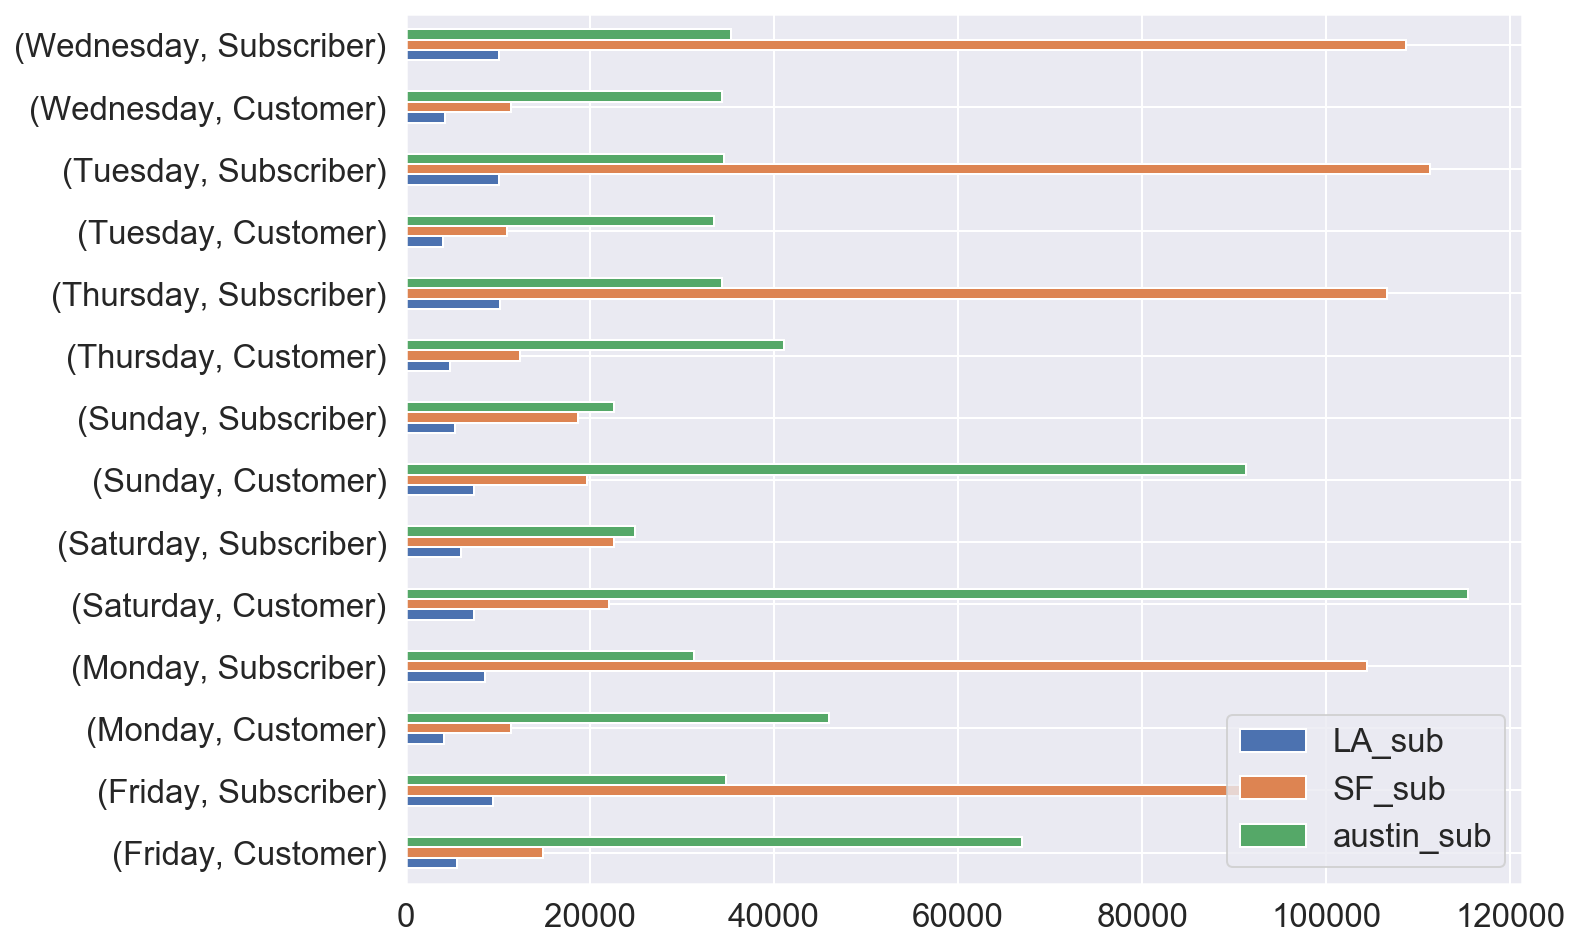

In [169]:
df_sub_LA = pd.DataFrame({'LA_sub':LA_sub,'SF_sub':SF_sub,'austin_sub':austin_sub})
df_sub_LA.plot.barh( figsize=(10,8));
# 'Chicago_sub':Chicago_sub